# **Black and White to Color GAN Engine**

This test started with 631 images of varying size. These images recieved the following augmentations:

*   resized to a maximum of 640x640 (original aspect ratio maintained) to make processing and analyzing easier
*   created flipped copies
*   created slightly rotated and zoomed copies of all of the images
*   created black and white copies for training

The resulting training set had 2,516 color and b/w image pairs to work with.

**Note on Training Images:** you can pull many from Google Images and then perform data resize and augmentation (mirror, rotate, shift, zoom) to increase the number of training images.  

It's honestly faster to do this part on your personal computer and then upload the resultant imageset to Google Drive because GD is **really** slow, but if you need to you can still do everything online once you have the URLs in a txt file and you'll see where to import the images in the code below. I have included some unrefactored code blocks at the bottom of this notebook that you'll want to run locally (not in the notebook) to take the "page source" from the search results and extract some of the image URLs as well as a block to pull down the images and perform transformations. They're not pretty, but they're functional for this experimental example.



## Pretrained GAN

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import glob
from pathlib import Path
from PIL import Image, ImageDraw
from numpy import asarray

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/bw2color'
print(f"base_dir = {base_dir}")

Mounted at /content/gdrive
base_dir = /content/gdrive/My Drive/fastai-v3/data/bw2color


In [3]:
path = Path(f'{base_dir}')

name_color = 'color'
path_color = f'{base_dir}/{name_color}'
name_bw = 'bw'
path_bw = f'{base_dir}/{name_bw}'
name_gen = 'image_gen'
s_path_gen = f"{base_dir}/{name_gen}"
path_gen = Path(s_path_gen)
urlFile = f"{base_dir}/bw2color.txt"

print(f"color dir: {path_color}")
print(f"bw dir: {path_bw}")
print(f"gen dir: {path_gen}")
print(f"url file: {urlFile}")

#Set value below to "True" if you need to reload images into Google Drive, and "False" if not.
#This is sketchy af so don't redo this if you don't have to. 
curDir = Path(path_color)
if False: 
  download_images(urlFile, path_color, max_pics=1318)

color dir: /content/gdrive/My Drive/fastai-v3/data/bw2color/color
bw dir: /content/gdrive/My Drive/fastai-v3/data/bw2color/bw
gen dir: /content/gdrive/My Drive/fastai-v3/data/bw2color/image_gen
url file: /content/gdrive/My Drive/fastai-v3/data/bw2color/bw2color.txt


## Black and white-ified data

Prepare the input data by conducting image augmentation and then converting all the color images to b/w images.

In [0]:
class bw_ifier(object):
    def __init__(self, path_color, path_bw):
      self.path_color = path_color
      self.path_bw = path_bw

    def __call__(self, fn, i):       
        dest = self.path_bw/fn.relative_to(self.path_color)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        img = img.convert('L') #.convert('RGB') #Convert mode 'L' changes to B/W
        img.save(dest, quality=90)

Uncomment the first time you run this notebook.

In [0]:
il = ImageList.from_folder(path_color)


In [6]:
il.items

array([PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00001015.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00001008.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00001009_f.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00001008_rz.jpg'), ...,
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00000323_f.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00000314_rz.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00000314_f_rz.jpg'),
       PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/color/00000323_rz.jpg')], dtype=object)

In [0]:
if False:  #Set to True if bw images not yet created
  parallel(bw_ifier(path_color, path_bw), il.items)

For gradual resizing we can change the commented line here.

In [8]:
bs, size = 30, 64     #Initial batch size and image size for the learner
bs2, size2 = 3,32     #1st round of GAN learning. Low numbers because the GPU keeps maxing out.
bs3, size3 = 16, 192  # Final GAN round of learning...added detail

#bs,size = 24,160
#bs,size = 64,64
learn_gen=None
gc.collect()

92

## Pre-train generator

Now let's pretrain the generator.

In [0]:
arch = models.resnet34  

In [0]:
src = ImageImageList.from_folder(path_bw).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: f"{path_color}/{x.name}")
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.2, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size, tfm_y=False)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=False))
    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

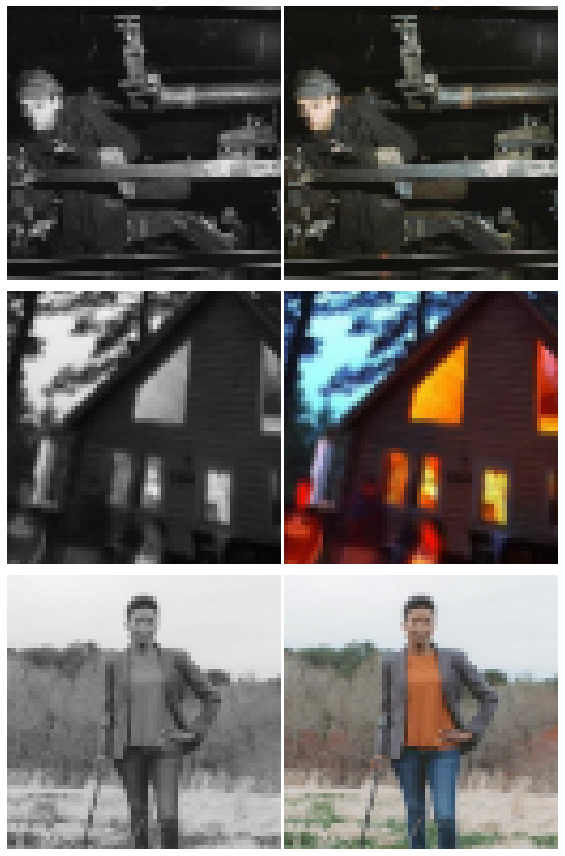

In [12]:
data_gen.show_batch(3)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
# !!try different losses here 
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=False, norm_type=NormType.Spectral,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


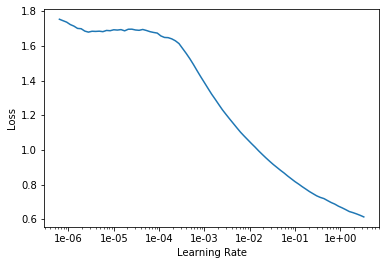

In [18]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [19]:
learn_gen.fit_one_cycle(4, pct_start=0.8)

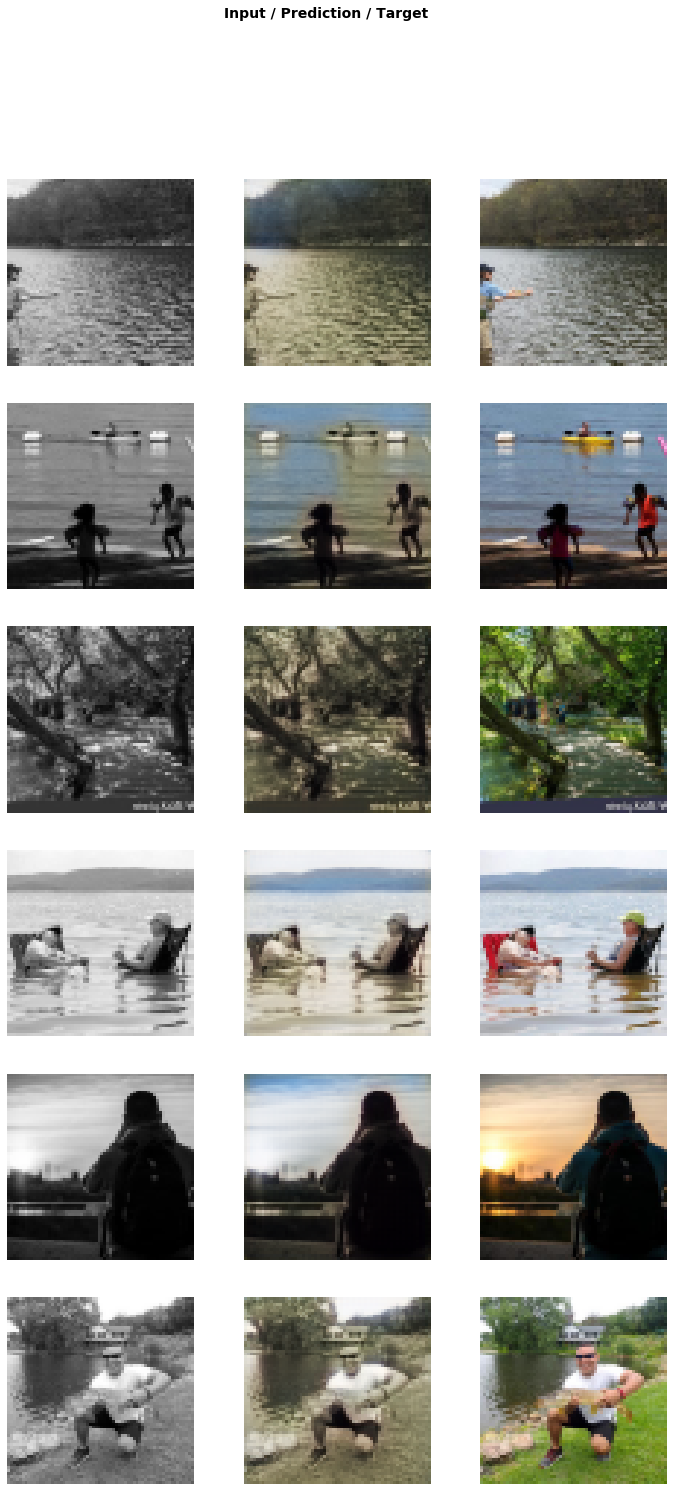

In [20]:
learn_gen.show_results(rows=6)

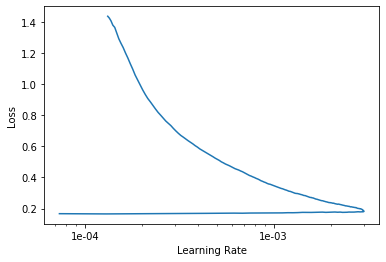

In [21]:
learn_gen.recorder.plot()

In [0]:
learn_gen.unfreeze()

In [23]:
learn_gen.fit_one_cycle(3, slice(1e-4,9e-3))

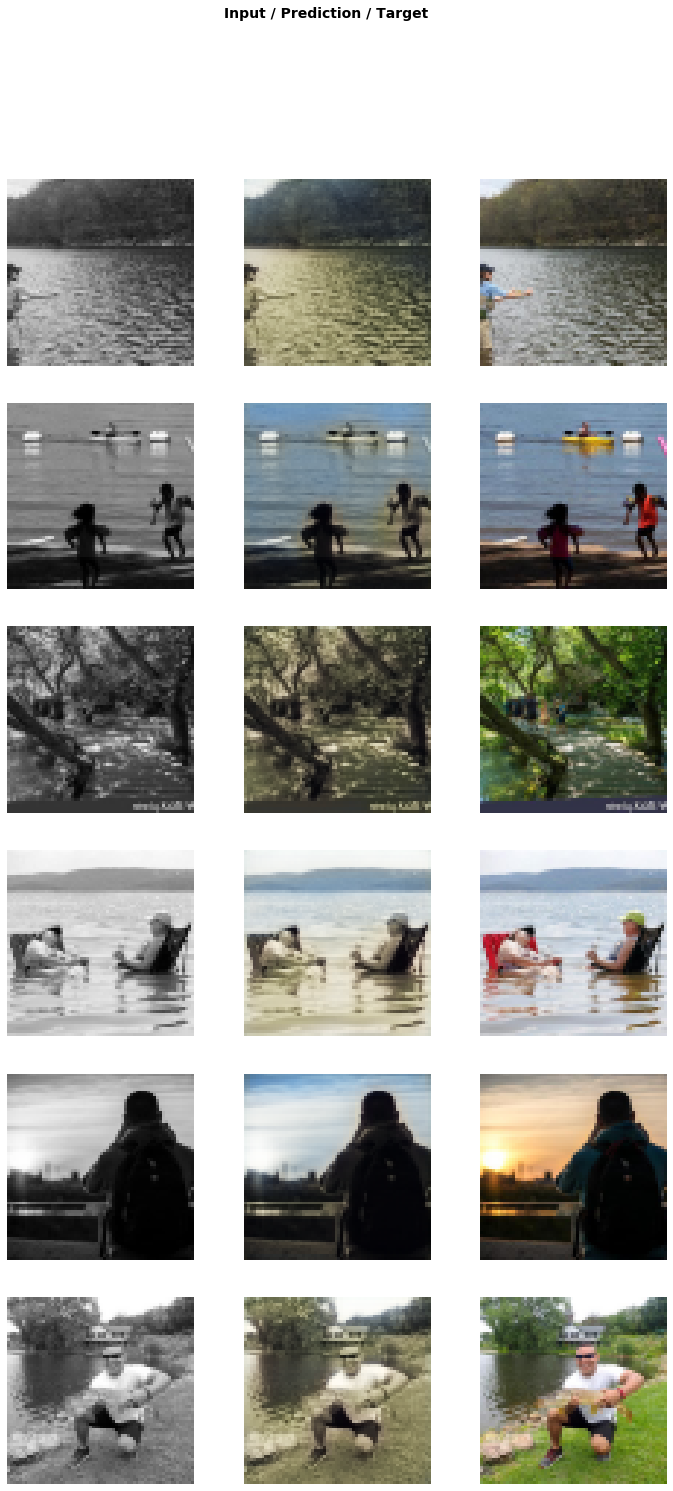

In [24]:
learn_gen.show_results(rows=6)

In [0]:
learn_gen.save('gen-pre3')

## Save generated images

In [0]:
# learn_gen.load('gen-pre3');

In [0]:
#shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

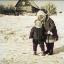

In [30]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [31]:
learn_gen=None
gc.collect()

20

Pretrain the critic on b/w vs color.

In [0]:
data_crit = get_crit_data([name_gen, 'color'], bs=bs, size=size)

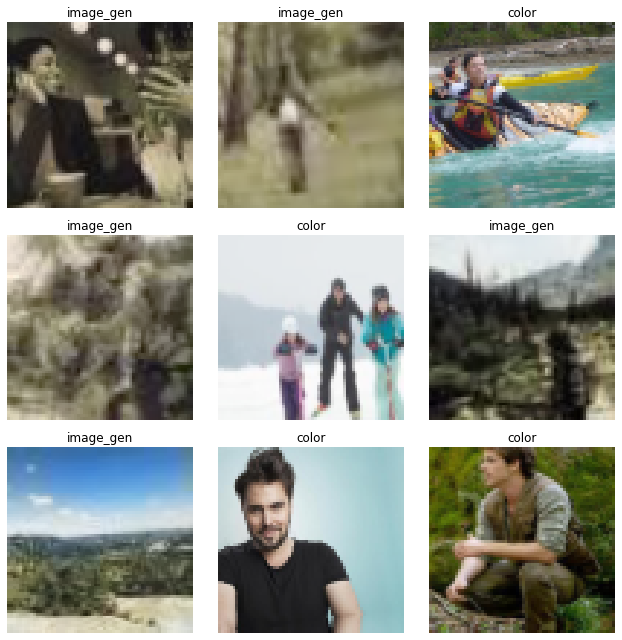

In [34]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [38]:
learn_critic.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


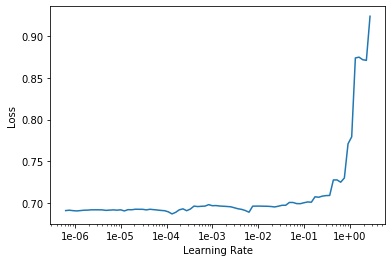

In [39]:
learn_critic.recorder.plot()

In [40]:
learn_critic.fit_one_cycle(3, 1e-2)

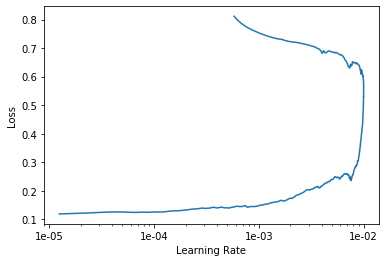

In [41]:
learn_critic.recorder.plot()

In [0]:
learn_critic.save('critic-pre3a')

## GAN

Now we'll combine those pretrained model in a GAN.



In [43]:
learn_crit=None
learn_gen=None
gc.collect()

13144

In [0]:
data_crit = get_crit_data([name_gen, 'color'], bs=bs2, size=size2)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2a')

In [0]:
learn_gen = create_gen_learner().load('gen-pre3')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-3

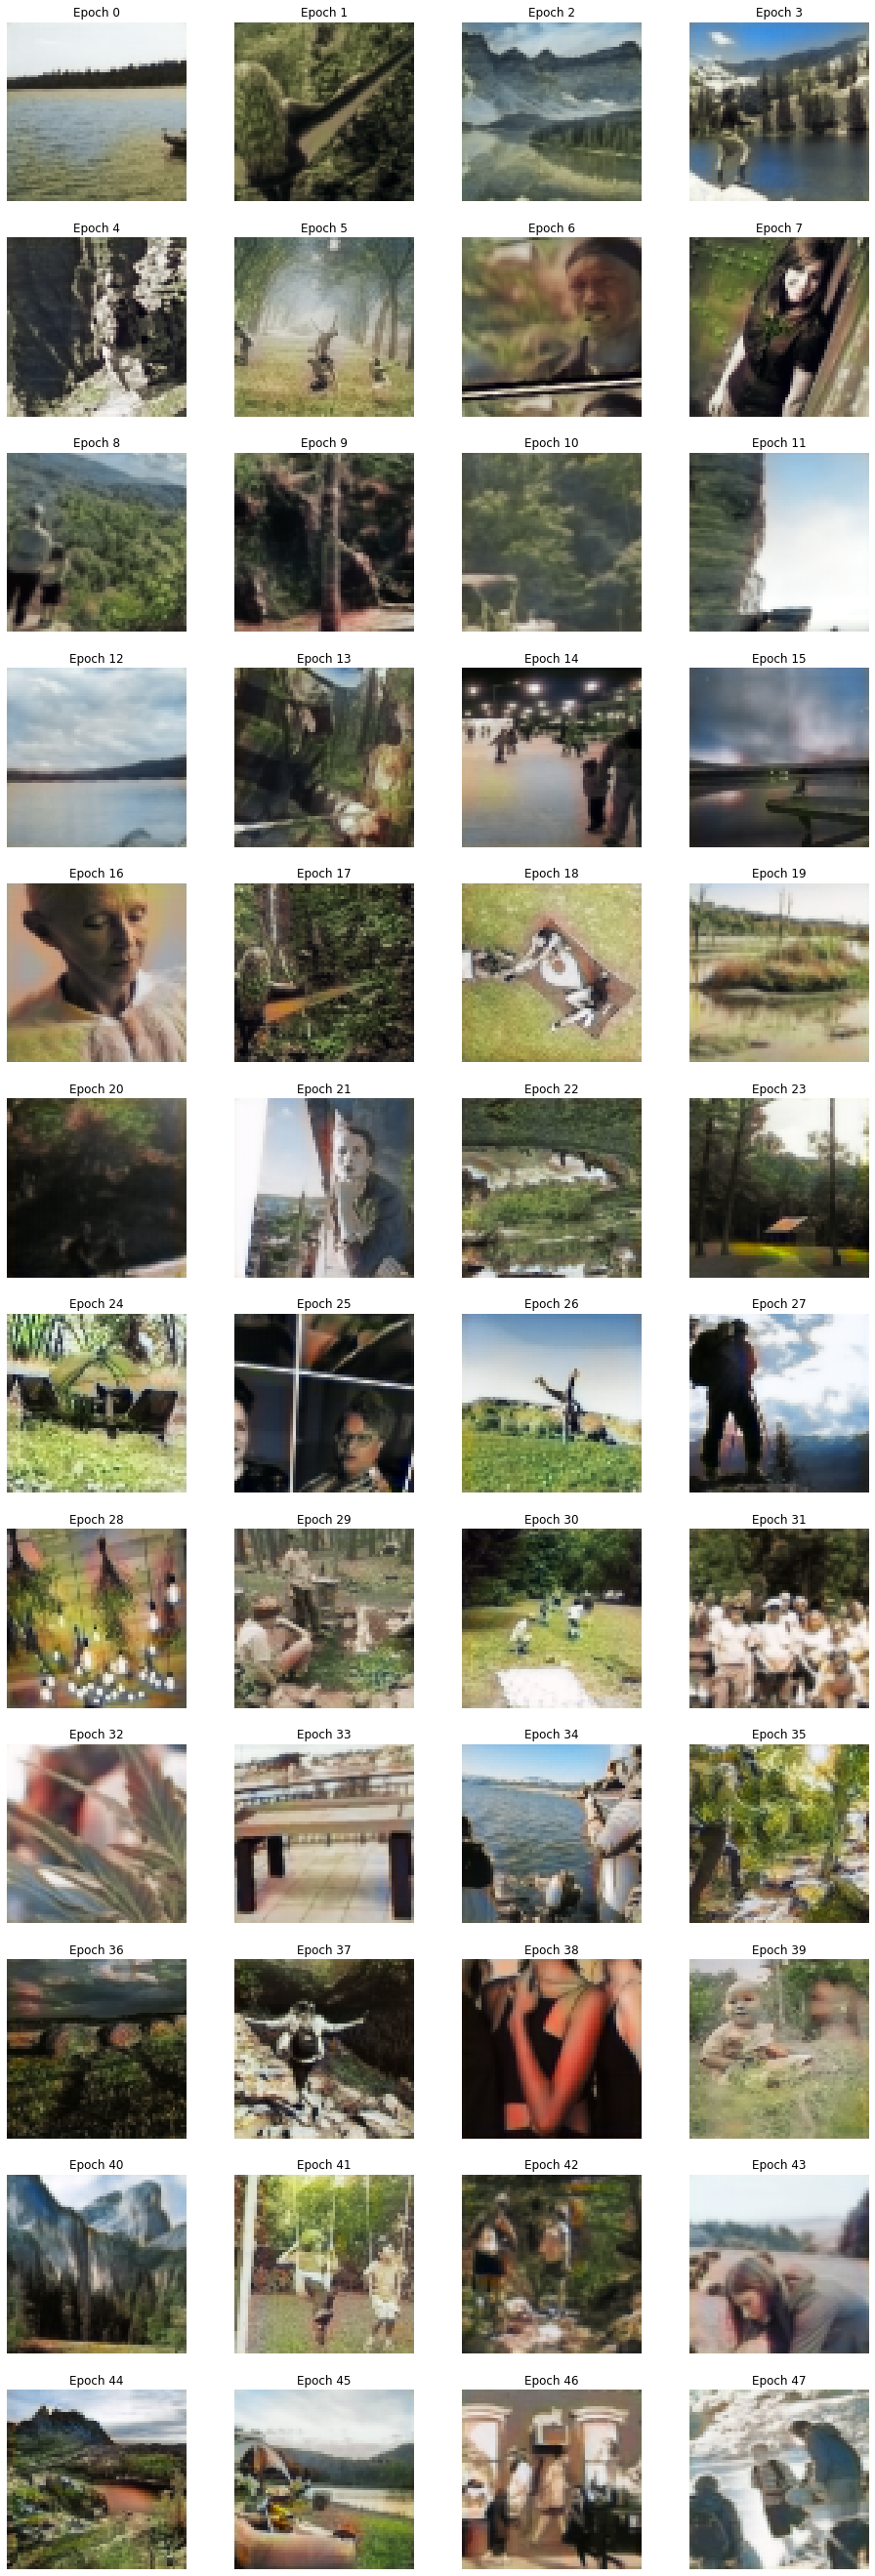

Buffered data was truncated after reaching the output size limit.

In [49]:
learn.fit(60,lr)  #it was 40

In [0]:
learn.save('gan-3ca')

In [0]:
learn.data=get_data(bs3, size3)
#learn.data = get_crit_data([name_gen, 'color'], bs=bs3, size=size3)

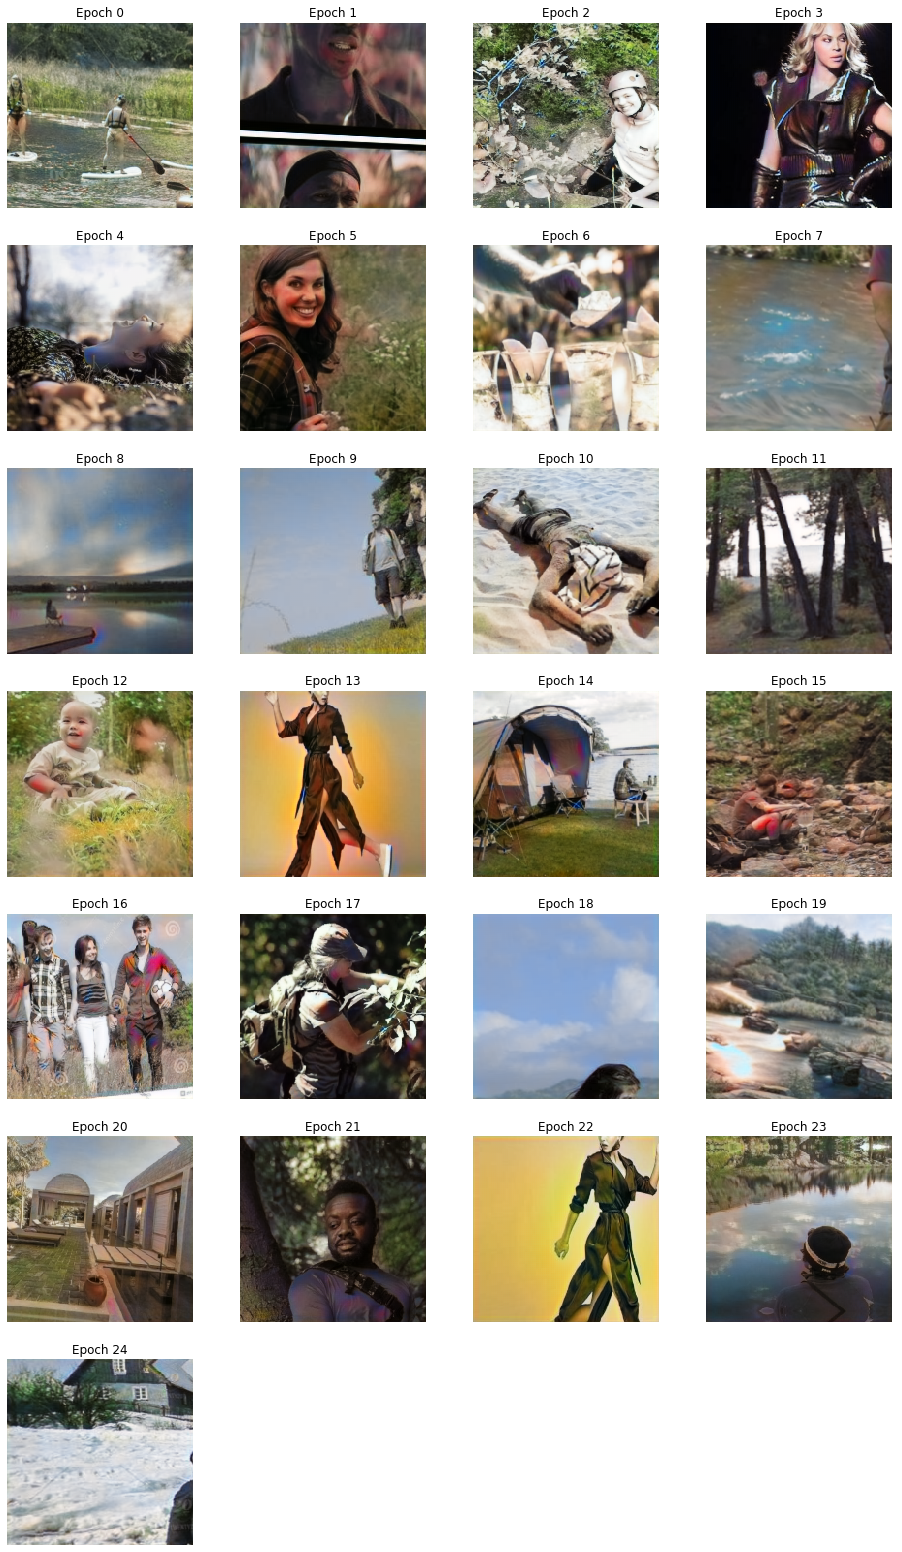

Buffered data was truncated after reaching the output size limit.

In [52]:
learn.fit(60,lr/2)

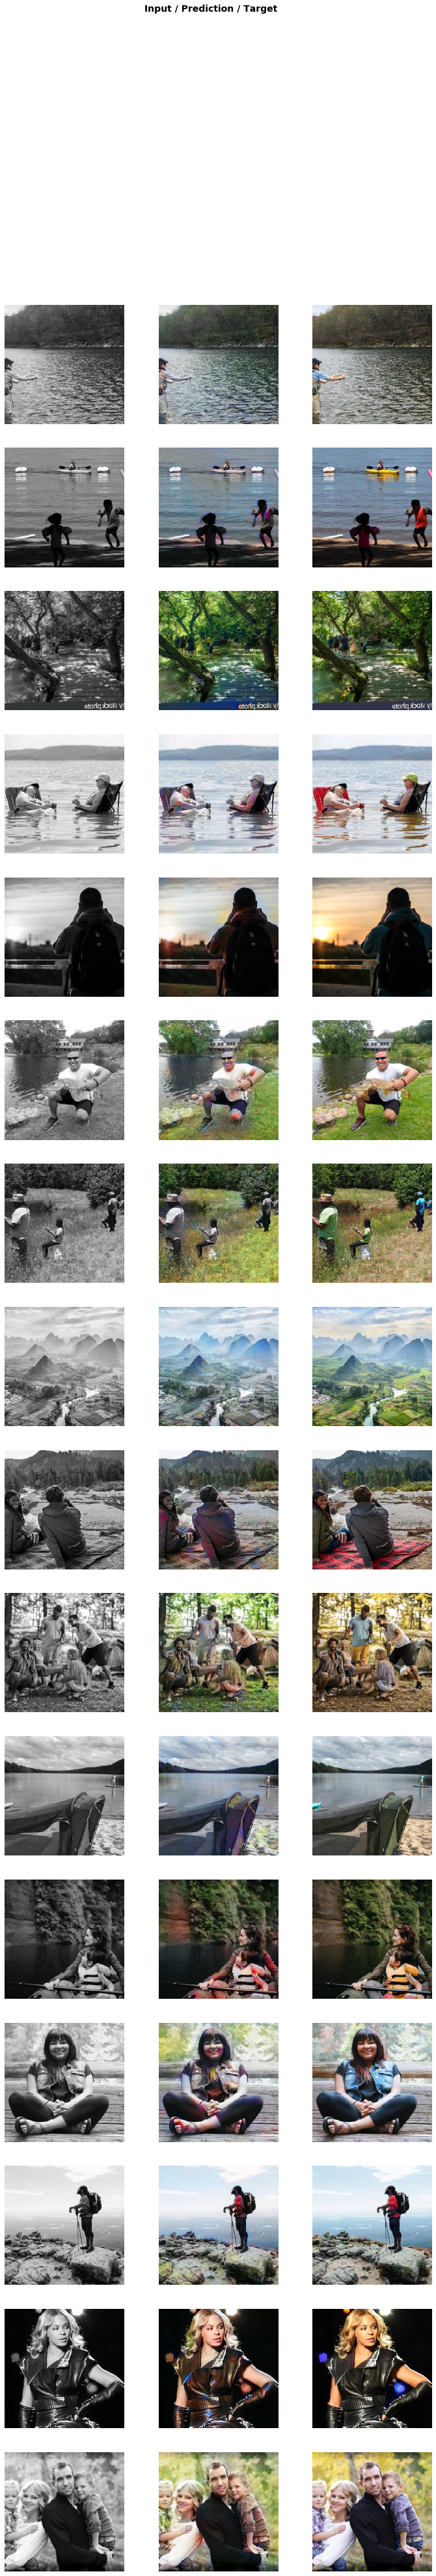

In [53]:
learn.show_results(rows=60)

In [0]:
learn.save('gan-3ca')

In [55]:
learn.save("colorizer_trained_model_3", return_path=True)

PosixPath('/content/gdrive/My Drive/fastai-v3/data/bw2color/bw/models/colorizer_trained_model_3.pth')

In [0]:
name_fam = 'fam'
path_fam = f'{base_dir}/{name_fam}'
src = ImageImageList.from_folder(path_fam)
file_no = 19

for filename in listdir(inDir):
  
#src[1]
# pic = f"{path_fam}/scan.jpg"  #Image_00031.png"
# pic
# img = open_image(pic)
# #img
# learn.predict(img)
# img.show(y=learn.predict(src[2])[0])
img = learn.predict(src[file_no])[0]
img
new_name = f"{path_fam}/color_{file_no}.jpg"
new_name
img.save(new_name)

IndentationError: ignored

## fin

**Don't run the code below in the notebook.**  Pull this locally to extract the URLs and download images to a local directory. Rename paths as needed.

In [0]:
DO NOT RUN THIS IN THE NOTEBOOK, RUN THIS LOCALLY BECAUSE GOOGLE DRIVE IS SLOW AS COLD MOLASSES 

import urllib.request
import os
import re

#This program will take the "view source" output from a Google Image search, extract the image URLs and download the images to a destination folder

#This is the output directory for the downloaded image files
path = "c:\\users\\username\\Desktop\\drive-download\\"
#This is the starting incrementor for outputted images. You will want to increment this periodically as you run this multiple times collecting images to avoid overwriting images 
OutputFileCounter = 1600 

NewFileCount = 0
with open(fname,encoding="utf8") as fin:
    line = fin.readline()
    while line:
        line = fin.readline()
        if line[0:11] ==  ',["https://':
            NewFileCount += 1
            ImageURL = ""
            if line.find(".jpg") > 0:
                ImageURL = re.search("https:\/\/.+\.jpg", line).group()
            elif line.find(".JPG") > 0:
                ImageURL = re.search("https:\/\/.+\.JPG", line).group()
            elif line.find(".png") > 0:
                ImageURL = re.search("https:\/\/.+\.png", line).group()
            elif line.find(".PNG") > 0:
                ImageURL = re.search("https:\/\/.+\.PNG", line).group()
            elif line.find(".jpeg") > 0:
                ImageURL = re.search("https:\/\/.+\.jpeg", line).group()
            elif line.find(".JPEG") > 0:
                ImageURL = re.search("https:\/\/.+\.JPEG", line).group()
            if ImageURL != "":
                print(f"URL {NewFileCount}: {ImageURL}")
                filename, file_extension = os.path.splitext(ImageURL)
                new_name = str(NewFileCount + OutputFileCounter) + file_extension
                image_name = path + new_name
                print(image_name)
                try:
                    urllib.request.urlretrieve(ImageURL, image_name)
                except:
                    pass #Something blocked the download. Move on.
                NewFileCount += 1
print("Done...")


**Don't run the code below in the notebook.**  Pull this locally to resize and apply fransformations to the downloaded images. Rename paths as needed.

In [0]:
DO NOT RUN THIS IN THE NOTEBOOK, RUN THIS LOCALLY BECAUSE GOOGLE DRIVE IS SLOW AS COLD MOLASSES 

from PIL import Image
from os import listdir
from matplotlib import image
import os

#Image resize max dimension (pixels)
MaxSize = 640
#Directory with source Images
inDir = "C:\\Users\\username\Desktop\\drive-download\\"
#Directory where "augmented images should go
outColorDir = "C:\\Users\\username\Desktop\\drive-download\\color_output\\"
outBwDir = "C:\\Users\\username\Desktop\\drive-download\\bw_output\\"

def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)

def save_image(img, filename):
    try:
        if str.upper(filename[-3:]) == "PNG":
            img.save(filename, 'PNG')
        else:
            img.save(filename)
    except:
        img.convert('RGB').save(filename)

# Resize all images into "outColorDir" destination directory and make a flipped copy
loaded_images = list()
for filename in listdir(inDir):
    short_fn, file_extension = os.path.splitext(filename)
    full_fn = inDir + filename
    if full_fn[-4] == "." or  full_fn[-5] == ".": 
        curr_image = Image.open(full_fn)
        # Resize image to a managable size while preserving the aspect ratio AND copy a flipped version
        try:
            curr_image.thumbnail((MaxSize,MaxSize))
            save_image(curr_image, outColorDir + filename)
            new_image = curr_image.transpose(Image.FLIP_LEFT_RIGHT)
            save_image(new_image, outColorDir + short_fn + '_f' + file_extension)
        except:
            # I don't really care if a few don't process
            print(f"{filename} burped out during the resize")
            pass

# Now go through all the above images to make more images with added slight rotation and zoom transforms
for filename in listdir(outColorDir):
	# load image
    full_fn = outColorDir + filename
    if full_fn[-4] == "." or  full_fn[-5] == ".": 
        short_fn, file_extension = os.path.splitext(filename)
        curr_image = Image.open(full_fn)
        try:
            # add a +-2 degree rotation
            new_image = curr_image.rotate(2)
            # ...and a 6% zoom
            new_image2 = zoom_at(new_image,(new_image.width/2), (new_image.height/2), 1.06)
            save_image(new_image2, outColorDir + short_fn + '_rz' + file_extension)
        except:
            # I still don't care if a few don't process
            print(f"{filename} burped out during the rotations, but if too many pop out we can look into it")
            pass

# Now make all those black and white, but with the same file names in another directory       
for filename in listdir(outColorDir):
	# load image
    full_fn = outColorDir + filename
    if full_fn[-4] == "." or  full_fn[-5] == ".": 
        curr_image = Image.open(full_fn)
        try:
            new_image = curr_image.convert(mode='L')
            new_image.save(outBwDir + filename)
        except:
            # I still don't care if a few don't process
            print(f"{filename} burped out during the b/w save...probably should delete this from both directories at this rate")
            pass

print("Done...")